In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy.stats import chi2_contingency
import math
from collections import Counter
from scipy.stats import entropy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from numpy import inf
from sklearn.model_selection import GridSearchCV



In [14]:
# Load the train and test datasets
Xtrain_scaled = np.load('Xtrain_scaled.npy')
Xtest_scaled = np.load('Xtest_scaled.npy')
Xtrainb_scaled = np.load('Xtrainb_scaled.npy')
Xtestb_scaled = np.load('Xtestb_scaled.npy')
ytrain = np.load('ytrain.npy')
ytest = np.load('ytest.npy')
df_train = pd.read_csv('../paths_CYF_trainData.csv')
df_test = pd.read_csv('../paths_CYF_testData.csv')


In [15]:
# Initial variables for the model. 
# I focus exclusively on the pre services and loc plus demographics with less than 20% of missing data.

id_cols = ['id', 'client_id']

demo_cols = ['age', 'age_group','race','gender','dx_group','lang', 'substance','insurance','liv']

ip_cols = ['as_loc', 'as_length_IP', 'IP_history', 'as_close']

loc_pre_cols = ['loc1_pre', 'loc2_pre', 'loc3_pre', 'loc4_pre', 'loc5_pre']

svc_total_pre_cols = ['svc_pre_all', 'svc_pre', 'svc_pre_sub']

svc_CYF_timepoint_pre_cols = ['svc_op_7days_pre', 'svc_op_30days_pre', 'svc_op_60days_pre', 'svc_op_90days_pre',
                     'svc_es_7days_pre', 'svc_es_30days_pre', 'svc_es_60days_pre', 'svc_es_90days_pre',
                     'svc_dt_7days_pre', 'svc_dt_30days_pre', 'svc_dt_60days_pre', 'svc_dt_90days_pre',
                     'svc_ip_7days_pre', 'svc_ip_30days_pre', 'svc_ip_60days_pre', 'svc_ip_90days_pre']

output_col = ['svc_CYF_ip_60days_postdc_bi']

drop_cols = ['']

In [16]:
numerical_features = ['age', 'as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_pre_sub']
numerical_features = numerical_features  + svc_CYF_timepoint_pre_cols
dummy_vars = df_train.loc[:, 'age_group_12-15 Yrs':'loc5_pre_WRAP']
dummy_vars = list(dummy_vars.columns)
categorical_features = dummy_vars + ['substance', 'new','CWS', 'ADS', 'JJ']
all_features = numerical_features + categorical_features

boruta_features = ['as_length_IP', 'IP_history', 'svc_pre_all', 'svc_pre', 'svc_op_30days_pre', 'svc_es_30days_pre', 'svc_ip_7days_pre', 'svc_ip_30days_pre', 'liv_House or Apartment', 'as_loc_IPCAPS', 'as_loc_IPFFS', 'as_close_Home/Shelter/Self']

In [17]:
Xtrain = df_train[all_features]
Xtrainb = df_train[boruta_features]

In [18]:
# Set a seed for reproducibility
SEED = 300
np.random.seed(SEED)

In [19]:
print(np.any(np.isnan(Xtrain_scaled)))
print(np.any(np.isnan(ytrain)))
#np.all(np.isfinite(Xtrain_scaled))

False
False


In [20]:
print(np.any(np.isnan(Xtest_scaled)))
print(np.any(np.isnan(ytest)))

False
False


### Fit all variables into the models

In [21]:
# import datetime
from datetime import datetime

# import a host of Scikit-learn models
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier

# import model metrics
from sklearn.metrics import *


def get_models():
    """Generate a library of base learners."""
    nb = GaussianNB()
    knn = KNeighborsClassifier(n_neighbors=3)
    lr = LogisticRegression(C=1, random_state=SEED, solver='liblinear', class_weight='balanced')
    nn = MLPClassifier((100, 50), early_stopping=True, random_state=SEED, max_iter=400, activation='tanh')
    dt = DecisionTreeClassifier(random_state=SEED, class_weight='balanced')
    rf = RandomForestClassifier(n_estimators=100, random_state=SEED, class_weight='balanced')
    gb = GradientBoostingClassifier(n_estimators=100, random_state=SEED)
    
    models = {'naive bayes': nb,
              'knn': knn,
              'logistic': lr,
              'mlp-nn': nn,
              'decision tree': dt,
              'random forest': rf,
              'gbm': gb
             }

    return models


def train_predict(model_list, xtrain, ytrain, xtest):
    """Fit models in list on training set and return preds"""
    P = np.zeros((ytest.shape[0], len(model_list)))
    P = pd.DataFrame(P)
    
    S = np.zeros((ytest.shape[0], len(model_list)))
    S = pd.DataFrame(S)
    
    print("Fitting models.")
    cols = list()
    model_cvs = {}

    for i, (name, m) in enumerate(models.items()):
        current_time = datetime.now() 
        print("%s..." % name, end=" ", flush=False)
        model_cvs[name] = m.fit(xtrain, ytrain)
        m.fit(xtrain, ytrain)
        P.iloc[:, i] = m.predict_proba(xtest)[:, 1]
        S.iloc[:, i] = m.predict(xtest)
        cols.append(name)
        time_elapsed = datetime.now() - current_time
        print("Time elapsed ", time_elapsed)
        print("done")

    P.columns = cols
    S.columns = cols
    
    print("Done.\n")
    return P, S, model_cvs

    
def evaluate(y_true, S, P):
    for m in P.columns:
        y_pred = S.loc[:, m]
        y_pred_proba = P.loc[:, m]
        acc = accuracy_score(y_true, y_pred)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1score = f1_score(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred_proba)
        ap = average_precision_score(y_true, y_pred_proba)
        print ("Accuracy : {:.4f}".format(acc))
        print("Precision : {:.4f}".format(precision))
        print("Recall : {:.4f}".format(recall))
        print("F1 score : {:.4f}".format(f1score))
        print("AUC score : {:.4f}".format(auc))
        print("AP score : {:.4f}".format(ap))
        print("\nClassification report : \n", classification_report(y_true, y_pred))
        print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))
        print("done.\n")  
    return acc, precision, recall, f1score, auc, ap

In [22]:
models = get_models()
P, S, model_cvs = train_predict(models, Xtrain_scaled, ytrain, Xtest_scaled)
evaluate(ytest, S, P)

Fitting models.
naive bayes... Time elapsed  0:00:00.233991
done
knn... Time elapsed  0:00:37.116999
done
logistic... Time elapsed  0:00:01.065004
done
mlp-nn... Time elapsed  0:00:25.005006
done
decision tree... Time elapsed  0:00:01.785000
done
random forest... Time elapsed  0:00:12.419999
done
gbm... Time elapsed  0:00:53.400994
done
Done.

Accuracy : 0.6866
Precision : 0.6236
Recall : 0.2882
F1 score : 0.3942
AUC score : 0.6873
AP score : 0.5356

Classification report : 
               precision    recall  f1-score   support

           0       0.70      0.90      0.79      1806
           1       0.62      0.29      0.39       989

    accuracy                           0.69      2795
   macro avg       0.66      0.60      0.59      2795
weighted avg       0.67      0.69      0.65      2795


Confusion matrix : 
 [[1634  172]
 [ 704  285]]
done.

Accuracy : 0.6436
Precision : 0.4974
Recall : 0.6684
F1 score : 0.5703
AUC score : 0.6859
AP score : 0.4956

Classification report : 
  

(0.7667262969588551,
 0.6895388076490439,
 0.6198179979777553,
 0.6528221512247071,
 0.8171313014589051,
 0.7416519353292818)

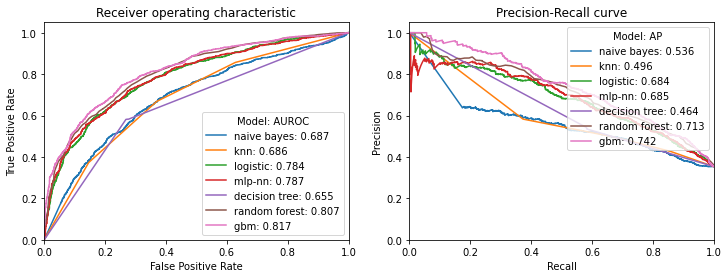

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in P.columns:
    roc_auc = roc_auc_score(ytest, P[column])
    fpr, tpr, _ = roc_curve(ytest, P[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, P[column])
    ave_prec_rec = average_precision_score(ytest, P[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

In [24]:
lr_importances = pd.Series(model_cvs['logistic'].coef_[0], index=Xtrain.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvs['logistic'].coef_[0]), index=Xtrain.columns, name = 'LR')
print("Top 15 features")
print(lr_importances.nlargest(15))

Top 15 features
svc_ip_90days_pre                           2.573655
svc_ip_60days_pre                           2.440285
loc5_pre_CR                                 1.753611
svc_ip_30days_pre                           1.647717
IP_history                                  1.642547
loc2_pre_DTCTF                              1.476262
as_close_Psychiatric Hospital               1.370454
svc_es_90days_pre                           1.248902
dx_group_Other/ Excluded                    0.880487
as_close_Homeless                           0.860188
loc1_pre_CM                                 0.845455
as_close_Required Lower Level\r\nof Care    0.797077
loc4_pre_CS                                 0.767572
as_close_Unknown                            0.728524
svc_es_60days_pre                           0.674692
Name: LR, dtype: float64


In [25]:
dt_importances = pd.Series(model_cvs['decision tree'].feature_importances_, index=Xtrain.columns, name = 'DT')
print("Top 15 features")
print(dt_importances.nlargest(15))

Top 15 features
IP_history           0.151874
as_length_IP         0.139518
svc_pre_all          0.050365
svc_ip_60days_pre    0.041814
svc_es_90days_pre    0.038716
as_loc_IPFFS         0.033458
age                  0.032634
as_loc_IPCAPS        0.030017
svc_pre              0.028867
svc_op_90days_pre    0.022133
svc_pre_sub          0.021207
svc_op_30days_pre    0.020647
svc_op_60days_pre    0.018747
svc_op_7days_pre     0.017202
svc_ip_7days_pre     0.014950
Name: DT, dtype: float64


In [26]:
rf_importances = pd.Series(model_cvs['random forest'].feature_importances_, index=Xtrain.columns, name = 'RF')
print("Top 15 features")
print(rf_importances.nlargest(15))

Top 15 features
as_length_IP         0.080980
IP_history           0.053304
svc_pre_all          0.040129
svc_ip_90days_pre    0.038030
age                  0.036089
svc_pre              0.034402
svc_op_90days_pre    0.030922
as_loc_IPFFS         0.030873
svc_ip_60days_pre    0.030017
svc_op_60days_pre    0.029492
svc_es_60days_pre    0.027682
svc_op_30days_pre    0.027122
svc_es_90days_pre    0.026562
svc_es_30days_pre    0.025129
svc_ip_30days_pre    0.022819
Name: RF, dtype: float64


In [27]:
gbm_importances = pd.Series(model_cvs['gbm'].feature_importances_, index=Xtrain.columns, name = 'GBM')
print("Top 15 features")
print(gbm_importances.nlargest(15))

Top 15 features
IP_history                    0.205693
as_length_IP                  0.185614
svc_ip_90days_pre             0.162465
as_loc_IPFFS                  0.087928
as_loc_IPCAPS                 0.078794
age                           0.034917
svc_ip_60days_pre             0.026601
as_close_Home/Shelter/Self    0.023943
svc_ip_7days_pre              0.022940
svc_pre_sub                   0.020178
svc_ip_30days_pre             0.017464
svc_es_60days_pre             0.015970
svc_op_7days_pre              0.015397
insurance_Other Insurance     0.015183
svc_op_90days_pre             0.008822
Name: GBM, dtype: float64


In [28]:
importances_df = pd.concat([lr_importances, dt_importances, rf_importances, gbm_importances], axis=1)
importances_df['avg'] = importances_df[['DT', 'RF', 'GBM']].mean(axis=1)
importances_df = importances_df.sort_values(by='avg', ascending=False)
importances_df.reset_index(inplace=True)
importances_df = importances_df.rename(columns = {'index':'Variable'})
importances_df.head(15)

,Variable,LR,DT,RF,GBM,avg
0,IP_history,1.642547,0.151874,0.053304,0.205693,0.136957
1,as_length_IP,-0.847320,0.139518,0.080980,0.185614,0.135371
2,svc_ip_90days_pre,2.573655,0.013321,0.038030,0.162465,0.071272
3,as_loc_IPFFS,-2.456569,0.033458,0.030873,0.087928,0.050753
4,as_loc_IPCAPS,-2.289948,0.030017,0.019802,0.078794,0.042871
5,age,-0.318951,0.032634,0.036089,0.034917,0.034547
6,svc_ip_60days_pre,2.440285,0.041814,0.030017,0.026601,0.032810
7,svc_pre_all,0.397761,0.050365,0.040129,0.001522,0.030672
8,svc_es_90days_pre,1.248902,0.038716,0.026562,0.006312,0.023863
9,svc_pre,-1.261721,0.028867,0.034402,0.001548,0.021606


In [29]:
# Select the top 15 variables
important_vars = list(importances_df.iloc[0:15,0])
important_vars

['IP_history',
 'as_length_IP',
 'svc_ip_90days_pre',
 'as_loc_IPFFS',
 'as_loc_IPCAPS',
 'age',
 'svc_ip_60days_pre',
 'svc_pre_all',
 'svc_es_90days_pre',
 'svc_pre',
 'svc_op_90days_pre',
 'svc_op_30days_pre',
 'svc_es_60days_pre',
 'svc_op_7days_pre',
 'as_close_Home/Shelter/Self']

### Fit Boruta-select variables into the models

In [30]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
evaluate(ytest, Sb, Pb)

Fitting models.
naive bayes... Time elapsed  0:00:00.026993
done
knn... Time elapsed  0:00:01.132005
done
logistic... Time elapsed  0:00:00.128998
done
mlp-nn... Time elapsed  0:00:15.026014
done
decision tree... Time elapsed  0:00:00.405000
done
random forest... Time elapsed  0:00:09.029000
done
gbm... Time elapsed  0:00:08.937998
done
Done.

Accuracy : 0.6930
Precision : 0.5755
Recall : 0.5046
F1 score : 0.5377
AUC score : 0.7140
AP score : 0.5861

Classification report : 
               precision    recall  f1-score   support

           0       0.75      0.80      0.77      1806
           1       0.58      0.50      0.54       989

    accuracy                           0.69      2795
   macro avg       0.66      0.65      0.65      2795
weighted avg       0.69      0.69      0.69      2795


Confusion matrix : 
 [[1438  368]
 [ 490  499]]
done.

Accuracy : 0.6887
Precision : 0.5522
Recall : 0.6360
F1 score : 0.5912
AUC score : 0.7144
AP score : 0.5285

Classification report : 
  

(0.7499105545617174,
 0.6494845360824743,
 0.6370070778564206,
 0.6431852986217458,
 0.8109478348209037,
 0.7435704024276557)

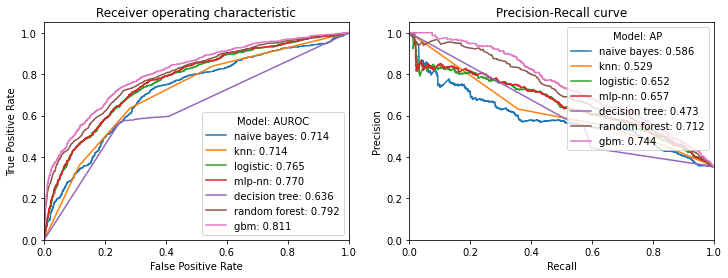

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pb.columns:
    roc_auc = roc_auc_score(ytest, Pb[column])
    fpr, tpr, _ = roc_curve(ytest, Pb[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pb[column])
    ave_prec_rec = average_precision_score(ytest, Pb[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

### Fit important variables into the models

In [32]:
Xtrain2 = df_train[important_vars]
Xtest2 = df_test[important_vars]
ytrain_original = df_train['svc_CYF_ip_60days_postdc_bi']


In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
Xtrain2_scaled = scaler.fit_transform(Xtrain2)
Xtest2_scaled = scaler.fit_transform(Xtest2)

In [34]:
# Class Imbalance Processing: Using re-sampling method
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=SEED)
Xtrain2_scaled, ytrain = sm.fit_sample(Xtrain2_scaled, ytrain_original)

In [35]:
models = get_models()
Pm, Sm, model_cvsm = train_predict(models, Xtrain2_scaled, ytrain, Xtest2_scaled)
evaluate(ytest, Sm, Pm)

Fitting models.
naive bayes... Time elapsed  0:00:00.050997
done
knn... Time elapsed  0:00:01.994014
done
logistic... Time elapsed  0:00:00.188987
done
mlp-nn... Time elapsed  0:00:26.217995
done
decision tree... Time elapsed  0:00:00.587992
done
random forest... Time elapsed  0:00:09.580000
done
gbm... Time elapsed  0:00:11.270012
done
Done.

Accuracy : 0.6966
Precision : 0.5989
Recall : 0.4317
F1 score : 0.5018
AUC score : 0.6730
AP score : 0.5634

Classification report : 
               precision    recall  f1-score   support

           0       0.73      0.84      0.78      1806
           1       0.60      0.43      0.50       989

    accuracy                           0.70      2795
   macro avg       0.66      0.64      0.64      2795
weighted avg       0.68      0.70      0.68      2795


Confusion matrix : 
 [[1520  286]
 [ 562  427]]
done.

Accuracy : 0.6336
Precision : 0.4869
Recall : 0.6582
F1 score : 0.5598
AUC score : 0.6780
AP score : 0.4978

Classification report : 
  

(0.47942754919499103,
 0.3977172958735733,
 0.916076845298281,
 0.5546372819100092,
 0.7287787478431069,
 0.6304194483048551)

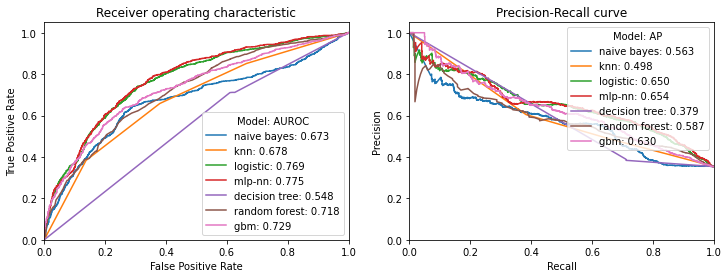

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))    
for column in Pm.columns:
    roc_auc = roc_auc_score(ytest, Pm[column])
    fpr, tpr, _ = roc_curve(ytest, Pm[column])
    ax[0].plot(fpr, tpr, label='%s: %0.3f' % (column, roc_auc))

    precision, recall, _ = precision_recall_curve(ytest, Pm[column])
    ave_prec_rec = average_precision_score(ytest, Pm[column])
    ax[1].plot(recall, precision, label='%s: %0.3f' % (column, ave_prec_rec))  

    ax[0].set_xlim([0.0, 1.0])
    ax[0].set_ylim([0.0, 1.05])
    ax[0].set_xlabel('False Positive Rate')
    ax[0].set_ylabel('True Positive Rate')
    ax[0].set_title('Receiver operating characteristic')
    ax[0].legend(loc="lower right", title="Model: AUROC")

    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_ylim([0.0, 1.05])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('Precision-Recall curve')
    ax[1].legend(loc="upper right", title="Model: AP")
   
#plt.savefig('mult_models_after_feat_select.png', format='png')

From the above results, I selected Gradient Boosting as my main model and the set of variables from the Boruta algorithms

## GBM tuning

In [37]:
param1 = {
    "n_estimators":[100,500,1000,1500],
    "learning_rate":[1, 0.1, 0.01, 0.001]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param1, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)


C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


GridSearchCV(cv=5,
             estimator=GradientBoostingClassifier(max_depth=4,
                                                  max_features='sqrt',
                                                  random_state=300,
                                                  subsample=1),
             iid=False, n_jobs=-1,
             param_grid={'learning_rate': [1, 0.1, 0.01, 0.001],
                         'n_estimators': [100, 500, 1000, 1500]},
             scoring='roc_auc')

In [38]:
tuning.best_params_, tuning.best_score_

({'learning_rate': 0.1, 'n_estimators': 500}, 0.8323697198933953)

In [39]:
param2 = {
   'max_depth':[2,3,4,5,6,7]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.1,n_estimators=500, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt', random_state=SEED), 
            param_grid = param2, scoring='roc_auc',n_jobs=-1, iid=False, cv=5)
tuning.fit(Xtrainb_scaled,ytrain)
tuning.best_params_, tuning.best_score_

C:\Users\Anh Tran\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


({'max_depth': 4}, 0.8323697198933953)

In [40]:
new=GradientBoostingClassifier(learning_rate=0.1, n_estimators=500, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1, max_features='sqrt' , random_state=SEED)
new.fit(Xtrainb_scaled,ytrain)


GradientBoostingClassifier(max_depth=4, max_features='sqrt', n_estimators=500,
                           random_state=300, subsample=1)

In [41]:
y_pred=new.predict(Xtestb_scaled)
y_pred_proba = new.predict_proba(Xtestb_scaled)[:, 1]
y_true = ytest
acc = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1score = f1_score(y_true, y_pred)
auc = roc_auc_score(y_true, y_pred_proba)
ap = average_precision_score(y_true, y_pred_proba)
print ("Accuracy : {:.4f}".format(acc))
print("Precision : {:.4f}".format(precision))
print("Recall : {:.4f}".format(recall))
print("F1 score : {:.4f}".format(f1score))
print("AUC score : {:.4f}".format(auc))
print("AP score : {:.4f}".format(ap))
print("\nClassification report : \n", classification_report(y_true, y_pred))
print("\nConfusion matrix : \n", confusion_matrix(y_true, y_pred))

Accuracy : 0.7653
Precision : 0.6980
Recall : 0.5935
F1 score : 0.6415
AUC score : 0.8077
AP score : 0.7462

Classification report : 
               precision    recall  f1-score   support

           0       0.79      0.86      0.83      1806
           1       0.70      0.59      0.64       989

    accuracy                           0.77      2795
   macro avg       0.75      0.73      0.73      2795
weighted avg       0.76      0.77      0.76      2795


Confusion matrix : 
 [[1552  254]
 [ 402  587]]


as_length_IP                  0.310539
IP_history                    0.177804
svc_es_30days_pre             0.098291
svc_op_30days_pre             0.070652
svc_ip_30days_pre             0.067420
as_loc_IPFFS                  0.060013
svc_pre_all                   0.055301
svc_pre                       0.053398
as_loc_IPCAPS                 0.040956
as_close_Home/Shelter/Self    0.034405
svc_ip_7days_pre              0.021572
liv_House or Apartment        0.009648
dtype: float64


Text(0, 0.5, 'Feature Importance Score')

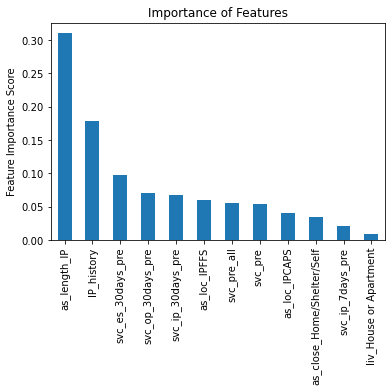

In [42]:
feat_imp = pd.Series(new.feature_importances_, index=Xtrainb.columns).sort_values(ascending=False)
print(feat_imp)
feat_imp.plot(kind='bar', title='Importance of Features')
plt.ylabel('Feature Importance Score')


In [43]:
models = get_models()
Pb, Sb, model_cvsb = train_predict(models, Xtrainb_scaled, ytrain, Xtestb_scaled)
lr_importances = pd.Series(model_cvsb['logistic'].coef_[0], index=Xtrainb.columns, name = 'LR')
lr_importances_abs = pd.Series(abs(model_cvsb['logistic'].coef_[0]), index=Xtrainb.columns, name = 'LR')
print(lr_importances)

Fitting models.
naive bayes... Time elapsed  0:00:00.098251
done
knn... Time elapsed  0:00:00.905009
done
logistic... Time elapsed  0:00:00.142998
done
mlp-nn... Time elapsed  0:00:11.648002
done
decision tree... Time elapsed  0:00:00.265997
done
random forest... Time elapsed  0:00:05.672995
done
gbm... Time elapsed  0:00:05.559998
done
Done.

as_length_IP                 -1.596086
IP_history                    2.529734
svc_pre_all                   0.404826
svc_pre                      -1.314142
svc_op_30days_pre             2.313307
svc_es_30days_pre             1.367971
svc_ip_7days_pre             -3.258150
svc_ip_30days_pre             4.107667
liv_House or Apartment       -0.304524
as_loc_IPCAPS                -1.369292
as_loc_IPFFS                 -1.567102
as_close_Home/Shelter/Self   -0.226659
Name: LR, dtype: float64


max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.\
min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.\
gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.\
subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.\
scale_pos_weight = 1: Because of high class imbalance.

### Archive codes

In [74]:
'''
# impute missing values of categorical features with the most frequent object
for col in categorical_features:
    df[col].fillna(df[col].value_counts().index[0], inplace=True)
'''

'\n# impute missing values of categorical features with the most frequent object\nfor col in categorical_features:\n    df[col].fillna(df[col].value_counts().index[0], inplace=True)\n'

In [75]:
'''
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
'''

"\ngsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,\n min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,\n objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), \n param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)\n"

In [76]:
'''
xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic',silent=True, nthread=4, 
                    scale_pos_weight=1, random_state=SEED)
grid_search = GridSearchCV(xgb, param_grid = parameters, scoring='roc_auc', n_jobs=4, iid=False, cv=5)
grid_search.fit(Xtrainb_scaled, ytrain)

# retrieve the best parameter set from grid search
print("\nGrid Search Best parameters set :")
print(grid_search.best_params_)
print("\nBest score: %0.3f" % grid_search.best_score_)
time_elapsed = (time.monotonic()-start_time)/60
print("Calculation took %.3f minutes" % time_elapsed)

'''

'\nxgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective=\'binary:logistic\',silent=True, nthread=4, \n                    scale_pos_weight=1, random_state=SEED)\ngrid_search = GridSearchCV(xgb, param_grid = parameters, scoring=\'roc_auc\', n_jobs=4, iid=False, cv=5)\ngrid_search.fit(Xtrainb_scaled, ytrain)\n\n# retrieve the best parameter set from grid search\nprint("\nGrid Search Best parameters set :")\nprint(grid_search.best_params_)\nprint("\nBest score: %0.3f" % grid_search.best_score_)\ntime_elapsed = (time.monotonic()-start_time)/60\nprint("Calculation took %.3f minutes" % time_elapsed)\n\n'

In [77]:
'''
def score_models(P, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        score = roc_auc_score(y, P.loc[:, m])
        ap = average_precision_score(y, P.loc[:, m])
        print("%-26s: %.3f, %.3f" % (m, score, ap))
    print("Done.\n")
    
def report_models(S, y):
    """Score model in prediction DF"""
    print("Scoring models.")
    for m in P.columns:
        report = classification_report(y, S.loc[:, m])
        print(report)
    print("Done.\n")

'''

'\ndef score_models(P, y):\n    """Score model in prediction DF"""\n    print("Scoring models.")\n    for m in P.columns:\n        score = roc_auc_score(y, P.loc[:, m])\n        ap = average_precision_score(y, P.loc[:, m])\n        print("%-26s: %.3f, %.3f" % (m, score, ap))\n    print("Done.\n")\n    \ndef report_models(S, y):\n    """Score model in prediction DF"""\n    print("Scoring models.")\n    for m in P.columns:\n        report = classification_report(y, S.loc[:, m])\n        print(report)\n    print("Done.\n")\n\n'

In [78]:
'''
param3 = {
   'min_samples_split':[4,8,10,20,40,60,80,100], 
    'min_samples_leaf':[1,3,5,7,9]
}

tuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), 
            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)
tuning.fit(X_train,y_train)
tuning.grid_scores_, tuning.best_params_, tuning.best_score_

'''

"\nparam3 = {\n   'min_samples_split':[4,8,10,20,40,60,80,100], \n    'min_samples_leaf':[1,3,5,7,9]\n}\n\ntuning = GridSearchCV(estimator =GradientBoostingClassifier(learning_rate=0.01, n_estimators=1500,max_depth=4, subsample=1,max_features='sqrt', random_state=SEED), \n            param_grid = param3, scoring='accuracy',n_jobs=-1, iid=False, cv=5)\ntuning.fit(X_train,y_train)\ntuning.grid_scores_, tuning.best_params_, tuning.best_score_\n\n"